In [1]:
import numpy as np
from itertools import product
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.metrics import pairwise_distances
from scipy.stats import entropy, spearmanr
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import trustworthiness
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import NearestNeighbors
import time
# Ignore Warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
n_samples = 10000
n_features = 100
np.random.seed(21)
data = np.random.normal(size=(n_samples, n_features))

In [3]:
# Helper function to calculate Kullback-Leibler Divergence
def kl_divergence(p_dist, q_dist):

    # Calculate betas using variance of distances
    beta_p = 1.0 / (2 * np.var(p_dist))
    beta_q = 1.0 / (2 * np.var(q_dist))
    
    # Transform to probabilities using respective betas
    p_prob = np.exp(-beta_p * p_dist)
    q_prob = np.exp(-beta_q * q_dist)
    
    # Set diagonal to zero
    np.fill_diagonal(p_prob, 0)
    np.fill_diagonal(q_prob, 0)
    
    # Normalize probabilities
    p_prob /= np.maximum(p_prob.sum(axis=1, keepdims=True), 1e-10)
    q_prob /= np.maximum(q_prob.sum(axis=1, keepdims=True), 1e-10)
    
    # Compute KL divergence
    kl_divs = []
    for i in range(len(p_prob)):
        p = np.maximum(p_prob[i], 1e-10)
        q = np.maximum(q_prob[i], 1e-10)
        kl_divs.append(entropy(p, q))
    
    return np.mean(kl_divs)

def shepard_stress(original_dist, reduced_dist):

    # Avoid division by zero by setting a small value where the original distance is zero
    original_dist[original_dist == 0] = 1e-10
    
    # Compute Shepard's stress
    stress_value = np.sqrt(np.sum((original_dist - reduced_dist) ** 2) / np.sum(original_dist ** 2))
    
    return stress_value

def calculate_continuity(original_data, reduced_data, k=5):
    n_samples = len(original_data)
    
    # Use NearestNeighbors for more efficient k-NN computation
    nn_original = NearestNeighbors(n_neighbors=k+1)
    nn_reduced = NearestNeighbors(n_neighbors=k+1)
    
    nn_original.fit(original_data)
    nn_reduced.fit(reduced_data)
    
    knn_original = nn_original.kneighbors(original_data, return_distance=False)[:, 1:]
    knn_reduced = nn_reduced.kneighbors(reduced_data, return_distance=False)[:, 1:]
    
    continuity_scores = [len(set(knn_original[i]) & set(knn_reduced[i])) / k 
                        for i in range(n_samples)]
    return np.mean(continuity_scores)

def spearman_rho(original_data, reduced_data):
    # Compute pairwise distances for original and reduced data
    original_distances = squareform(pdist(original_data, metric='euclidean'))
    reduced_distances = squareform(pdist(reduced_data, metric='euclidean'))
    
    # Flatten the distance matrices to compute Spearman correlation
    original_flat = original_distances.ravel()
    reduced_flat = reduced_distances.ravel()
    
    # Compute Spearman's rank correlation coefficient
    rho, _ = spearmanr(original_flat, reduced_flat)
    return rho

def calculate_mrre(original_dist, reduced_dist, original_data):

    # Rank the distances for both original and reduced data
    original_rank = np.argsort(np.argsort(original_dist, axis=1), axis=1)
    reduced_rank = np.argsort(np.argsort(reduced_dist, axis=1), axis=1)

    # Compute the absolute rank difference
    rank_diff = np.abs(original_rank - reduced_rank)

    # Normalize by the total number of points (n-1)
    n_samples = len(original_data)
    mrre = np.mean(rank_diff / (n_samples - 1))

    return mrre
        
# Calculate metrics
def evaluate_performance(original_data, reduced_data, model_name):

    # Compute pairwise distances for original and reduced data
    original_dist = pairwise_distances(original_data, metric='euclidean')
    reduced_dist = pairwise_distances(reduced_data, metric='euclidean')
    
    kl_div = kl_divergence(original_dist, reduced_dist)
    trust = trustworthiness(original_data, reduced_data)
    stress = shepard_stress(original_dist, reduced_dist)
    continuity = calculate_continuity(original_data, reduced_data)
    rho = spearman_rho(original_data, reduced_data)
    mrre = calculate_mrre(original_dist, reduced_dist, original_data)

    print(f"{model_name}:")
    print(f"  Kullback-Leibler Divergence: {kl_div:.4f}")
    print(f"  Trustworthiness: {trust:.4f}")
    print(f"  Continuity: {continuity:.4f}")
    print(f"  Shepard Stress: {stress:.4f}")
    print(f"  rho: {rho:.4f}")
    print(f"  MRRE: {mrre:.4f}")


    return(kl_div, 1 - trust, 1 - continuity, stress, (1-rho)/2, mrre)    

def reduction_scorer(original_data, reduced_data, weights, model_name):
    metrics = evaluate_performance(original_data, reduced_data, model_name)

        # Multiply each metric by its corresponding weight
    weighted_metrics = np.array(metrics) * np.array(weights)
    
    # Return the sum of the weighted metrics
    weighted_sum = weighted_metrics.sum()
    
    return weighted_sum

In [4]:
# UMAP
# Grid search parameters
n_neighbors = [2, 3, 4]
min_dist = [0.1, 0.05, 0.01]


best_score = np.inf
best_data_umap = None
best_params = tuple()
best_umap_model = None

for n, dist in product(n_neighbors, min_dist):
    print(f"Testing combination: \
n_neighbors={n}, min_dist={dist}")
    
    # Initialize the UMAP model with the current parameters
    umap_model = umap.UMAP(
        n_components=2,  
        metric="euclidean", 
        random_state=21,
        #n_jobs = -1,
        n_neighbors=n,
        min_dist=dist
    )


    start_time = time.time()

    # UMAP fitting and transformation
    data_umap = umap_model.fit_transform(data)
    
    score = reduction_scorer(data, data_umap, [0.2,0.2,0.2,0.2,0.2,0.1], "UMAP")

    end_time = time.time()


    print(f"Weighted Score for Testing combination: \
n_neighbors={n}, min_dist={dist} is {score}")
    print(f"Time taken: {end_time - start_time:.2f} seconds\n")

    if score < best_score:
        best_score = score
        best_data_umap = data_umap
        best_params = (n, dist)
        best_umap_model = umap_model


print(f"\nBest Weighted Score is {best_score} for combination: \
n_neighbors={best_params[0]}, min_dist={best_params[1]}")

Testing combination: n_neighbors=2, min_dist=0.1
UMAP:
  Kullback-Leibler Divergence: 0.0926
  Trustworthiness: 0.6937
  Continuity: 0.0423
  Shepard Stress: 0.4652
  rho: 0.0059
  MRRE: 0.3321
Weighted Score for Testing combination: n_neighbors=2, min_dist=0.1 is 0.49696700370611807
Time taken: 122.01 seconds

Testing combination: n_neighbors=2, min_dist=0.05
UMAP:
  Kullback-Leibler Divergence: 0.0926
  Trustworthiness: 0.6921
  Continuity: 0.0432
  Shepard Stress: 0.4617
  rho: 0.0096
  MRRE: 0.3315
Weighted Score for Testing combination: n_neighbors=2, min_dist=0.05 is 0.49600291925150863
Time taken: 107.15 seconds

Testing combination: n_neighbors=2, min_dist=0.01
UMAP:
  Kullback-Leibler Divergence: 0.0927
  Trustworthiness: 0.6915
  Continuity: 0.0427
  Shepard Stress: 0.4604
  rho: 0.0052
  MRRE: 0.3320
Weighted Score for Testing combination: n_neighbors=2, min_dist=0.01 is 0.49646620794058005
Time taken: 102.56 seconds

Testing combination: n_neighbors=3, min_dist=0.1
UMAP:
  

In [6]:
# t-SNE
perplexity = np.linspace(30, 36, 7).tolist()

best_score = np.inf
best_data_tsne = None
best_params = None
best_tsne = None

for p in perplexity:
    print(f"Testing perplexity: {p}")
    
    tsne = TSNE(
    n_jobs=-1,  
    n_components=2,  
    perplexity=p,  
    metric="euclidean",  
    random_state=21  
    )

    start_time = time.time()
    
    data_tsne = tsne.fit_transform(data)
    
    score = reduction_scorer(data, data_tsne, [0.25, 0.25, 0.25, 0.1, 0.1, 0.05], "TSNE")

    end_time = time.time()
    
    print(f"Weighted Score for Testing perplexity:{p} \
is {score}")
    print(f"Time taken: {end_time - start_time:.2f} seconds\n")
    
    if score < best_score:
        best_score = score
        best_data_tsne = data_tsne
        best_params = p
        best_tsne = tsne


print(f"\nWeighted Score is {best_score} for perplexity:{p} \
{best_params}")

Testing perplexity: 30.0
TSNE:
  Kullback-Leibler Divergence: 0.0889
  Trustworthiness: 0.7725
  Continuity: 0.1989
  Shepard Stress: 0.9025
  rho: 0.1583
  MRRE: 0.3085
Weighted Score for Testing perplexity:30.0 is 0.42714560289744796
Time taken: 126.72 seconds

Testing perplexity: 31.0
TSNE:
  Kullback-Leibler Divergence: 0.0889
  Trustworthiness: 0.7640
  Continuity: 0.1924
  Shepard Stress: 0.6917
  rho: 0.1583
  MRRE: 0.3084
Weighted Score for Testing perplexity:31.0 is 0.4097871365372094
Time taken: 127.11 seconds

Testing perplexity: 32.0
TSNE:
  Kullback-Leibler Divergence: 0.0889
  Trustworthiness: 0.7566
  Continuity: 0.1856
  Shepard Stress: 0.5578
  rho: 0.1553
  MRRE: 0.3087
Weighted Score for Testing perplexity:32.0 is 0.40012029572478114
Time taken: 128.24 seconds

Testing perplexity: 33.0
TSNE:
  Kullback-Leibler Divergence: 0.0889
  Trustworthiness: 0.7243
  Continuity: 0.1565
  Shepard Stress: 0.4385
  rho: 0.1654
  MRRE: 0.3070
Weighted Score for Testing perplexity:3

In [8]:
# PCA
pca = PCA(n_components=2, random_state=21)
data_pca = pca.fit_transform(data)

In [12]:
evaluate_performance(data, best_data_umap, "UMAP")
evaluate_performance(data, best_data_tsne, "t-SNE")
evaluate_performance(data, data_pca, "PCA")
print("\n")

UMAP:
  Kullback-Leibler Divergence: 0.0926
  Trustworthiness: 0.6921
  Continuity: 0.0432
  Shepard Stress: 0.4617
  rho: 0.0096
  MRRE: 0.3315
t-SNE:
  Kullback-Leibler Divergence: 0.0889
  Trustworthiness: 0.7566
  Continuity: 0.1856
  Shepard Stress: 0.5578
  rho: 0.1553
  MRRE: 0.3087
PCA:
  Kullback-Leibler Divergence: 0.1526
  Trustworthiness: 0.5539
  Continuity: 0.0009
  Shepard Stress: 0.8674
  rho: 0.1406
  MRRE: 0.3059




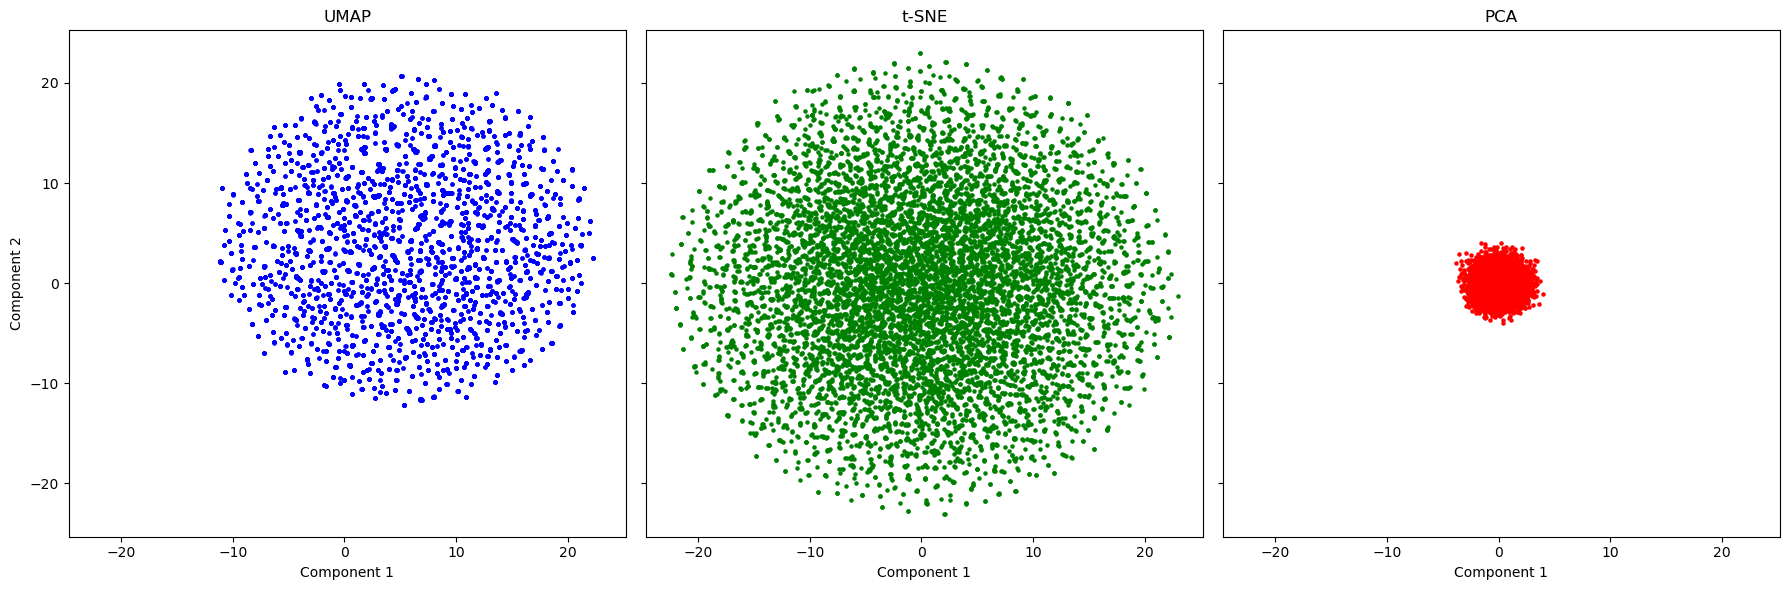

In [14]:
import matplotlib.pyplot as plt

# Assuming `best_data_umap`, `best_data_tsne`, and `best_data_pca` contain reduced data
x_umap = [i[0] for i in best_data_umap]
y_umap = [i[1] for i in best_data_umap]

x_tsne = [i[0] for i in best_data_tsne]
y_tsne = [i[1] for i in best_data_tsne]

x_pca = [i[0] for i in data_pca]
y_pca = [i[1] for i in data_pca]

# Create the grid plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot UMAP
axes[0].scatter(x_umap, y_umap, color='blue', s=5, label='UMAP Reduced Data')
axes[0].set_title('UMAP')
axes[0].set_xlabel('Component 1')
axes[0].set_ylabel('Component 2')

# Plot t-SNE
axes[1].scatter(x_tsne, y_tsne, color='green', s=5, label='t-SNE Reduced Data')
axes[1].set_title('t-SNE')
axes[1].set_xlabel('Component 1')

# Plot PCA
axes[2].scatter(x_pca, y_pca, color='red', s=5, label='PCA Reduced Data')
axes[2].set_title('PCA')
axes[2].set_xlabel('Component 1')

# Adjust layout and show
plt.tight_layout()
plt.show()

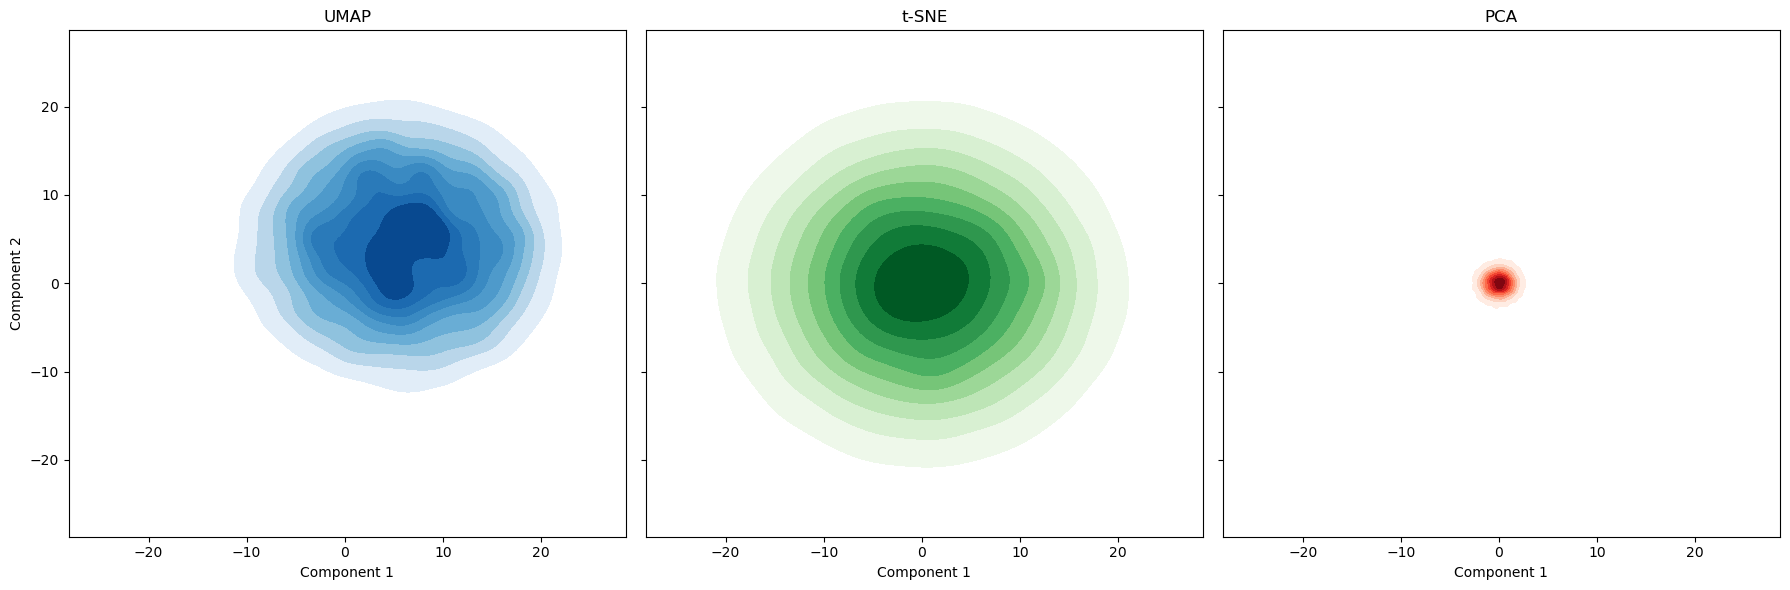

In [21]:
import seaborn as sns
# Create the grid plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot UMAP
sns.kdeplot(x=x_umap, y=y_umap, cmap='Blues', fill=True, ax=axes[0])
axes[0].set_title('UMAP')
axes[0].set_xlabel('Component 1')
axes[0].set_ylabel('Component 2')

# Plot t-SNE
sns.kdeplot(x=x_tsne, y=y_tsne, cmap='Greens', fill=True, ax=axes[1])
axes[1].set_title('t-SNE')
axes[1].set_xlabel('Component 1')
axes[1].set_ylabel('')

# Plot PCA
sns.kdeplot(x=x_pca, y=y_pca, cmap='Reds', fill=True, ax=axes[2])
axes[2].set_title('PCA')
axes[2].set_xlabel('Component 1')
axes[2].set_ylabel('')

# Adjust layout and show
plt.tight_layout()
plt.show()

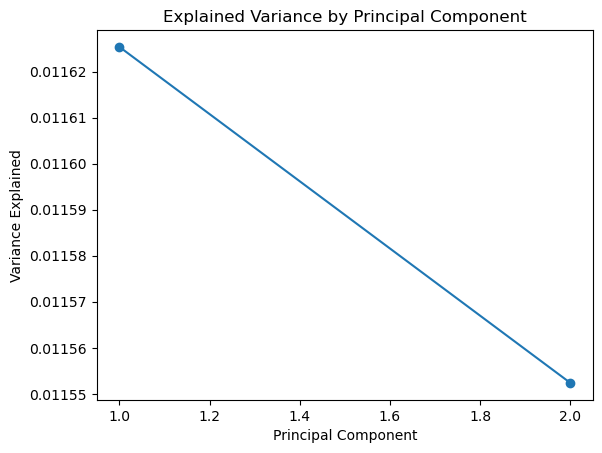

In [16]:
explained_variance = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title("Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.show()